# Asymmetric Experience Reply (ER_AML - ER_ACE)

## Paper results

Import of libraries and loading of results.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

with open('results.json') as file:
    results = json.load(file)

Loading test results.

In [2]:
test_results = {}
to_perc = lambda x: f'{round(x * 100, 2)} %'

for k, v in results.items():
    AAA, accuracy, hyperparams, _ = v['test']
    test_results[k] = dict(AAA=to_perc(AAA), accuracy=to_perc(accuracy), **json.loads(hyperparams))

### 1. Project objectives

ER_ACE and ER_AML are two techniques used in deep continual learning field. Both of them are able to compute the loss function in an asymmetric way so dividing it in a sum of two losses:
- `loss_in`: Loss computed on new minibatch of the current experience
- `loss_buffer`: Loss computed on a replay memory called buffer

Both the techniques uses replay memory that is balanced over classes and compute the `loss_buffer` using cross entropy loss. The difference between the two methods are in the `loss_in`:

- `ER_AML`: it is able to sample positive and negative examples from memory related to each example in the current minibatch and compute the exponential of cosine similarity between each example of minibatch and related positive and negative examples. In practice, we want to minimize the distance between new examples and stored examples of the same class. The similarity is computed between features of inputs; in fact the model should provide hidden features used to compare examples and compute their similarity.
- `ER_ACE`: it is able to approximate the ER_AML behavior using cross entropy. It computes the cross entropy loss of new minibatch examples with respect to related targets but masking to zero classes already seen.

Resources used during implementation are:
- [avalanche](https://github.com/ContinualAI/avalanche): For strategy construction and ResNet18 model
- [continual-learning-baselines](https://github.com/ContinualAI/continual-learning-baselines): For test comparisons and hyperparameters selection
- [AML](https://github.com/pclucas14/AML): Official repository of the paper. Used for AML and ACE strategy construction

### 2. Any critical part of the implementation

The most critical part is related to the memory size when is used AML technique. ER_AML to compute positive and negative example exploits all the memory. In case of big memory it scales bad. Two improvements that could be done is:
- Optimize implementation sampling without use all the memory each time but part of it
- Use the buffer sampled from the memory to sample positive and negatives (the same used to compute positive and negative examples)

### 3. Overview of the results

It's done a model selection using grid search algorithms and results are saved in `results.json` file. Validation is done using holdout approach with validation percentage that is the 10% of training set. After having found best hyperparameters that maximizes AAA metric we retrain the model from scratch on all the training stream and evaluate it on test stream. Hyperparameters tested in model selection phase are the same of the paper (and related code). In particular for ER_AML they are:
- strategy_train_mb_size=[10],
- strategy_eval_mb_size=[10],
- strategy_train_epochs=[1],
- strategy_mem_size=[100],
- strategy_batch_size_mem=[10],
- strategy_temp=[0.1, 0.2],
- sgd_lr=[0.1, 0.01, 0.001],
- sgd_momentum=[0]

and the same except `strategy_temp` for ER_ACE.

Here are shown test results. They are lower by the ones on paper.

In [3]:
pd.DataFrame(test_results)

,ER_AML,ER_ACE
AAA,15.46 %,19.6 %
accuracy,5.07 %,11.72 %
strategy_train_mb_size,10,10
strategy_eval_mb_size,10,10
strategy_train_epochs,1,1
strategy_mem_size,100,100
strategy_batch_size_mem,10,10
strategy_temp,0.1,NaN
sgd_lr,0.1,0.1
sgd_momentum,0,0


Plot of ER_AML and ER_ACE accuracy over experiences.

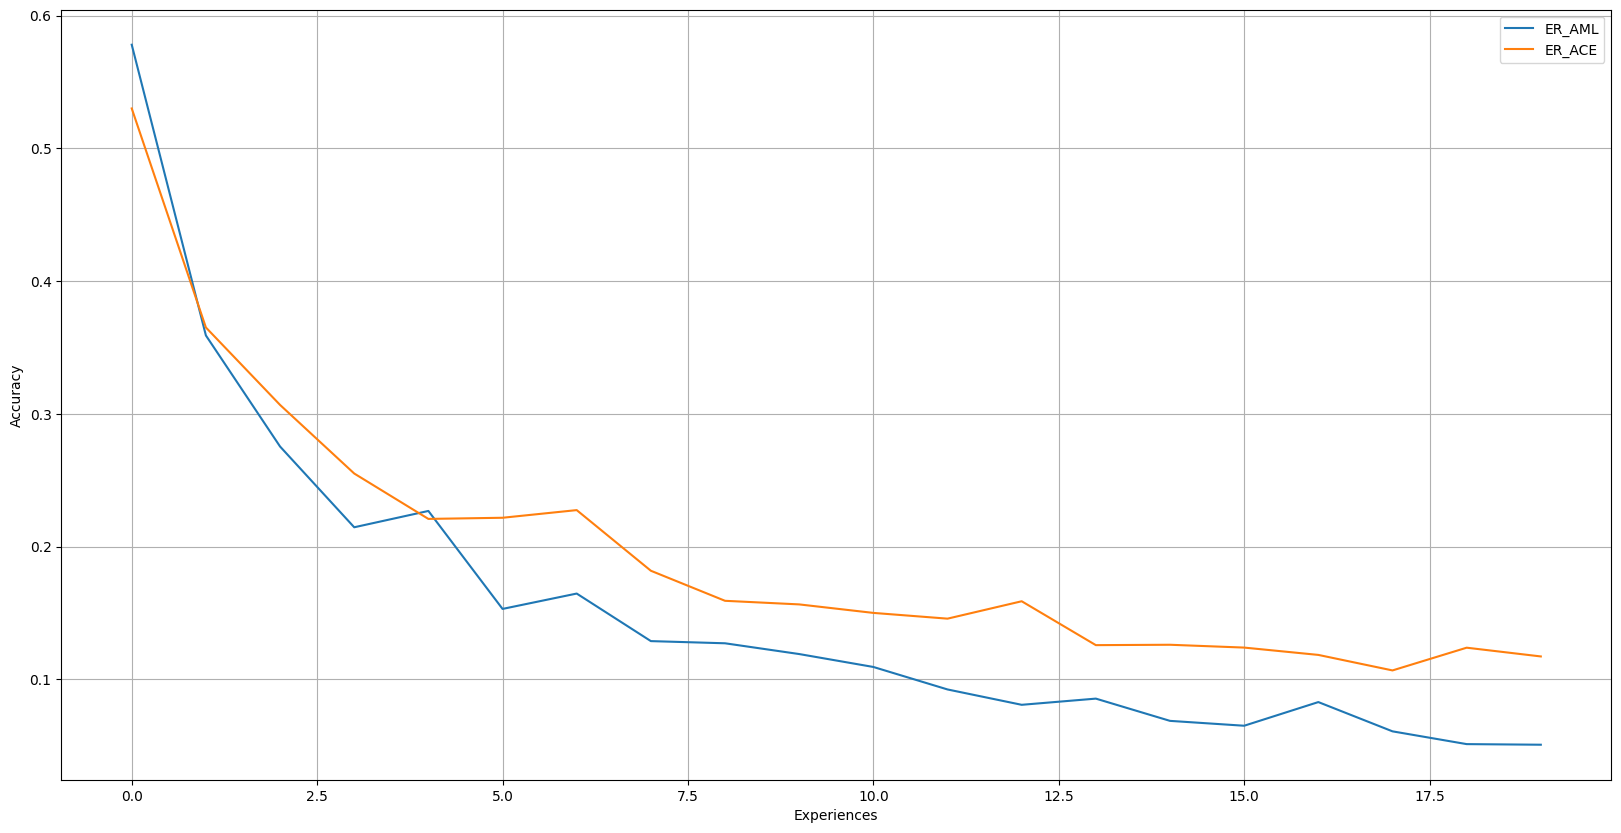

In [4]:
accuracy_over_exp = {k: [sum(x.values()) / len(x.values()) for x in v['test'][3]] for k, v in results.items()}

plt.figure(figsize=(20, 10))
for k, v in accuracy_over_exp.items():
    plt.plot(v, label=k)
plt.xlabel('Experiences')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

### 4. Conclusion
We expect better results comparable with the ones shown on the paper but they are lower. We understand that an improvement can be done enlarging the memory size as in the test done in [https://github.com/ContinualAI/continual-learning-baselines](https://github.com/ContinualAI/continual-learning-baselines) library. We will make comparisons between our implementation and the avalanche one using best hyperparameters and memory size set to 10000.

The difference between this implementation (ER_ACE) and avalanche one (ER_ACE_AVALANCHE) is related to the replay memory:
- ER_ACE: the buffer is updated at each iteration as described in the paper and the related code (also in ER_AML)
- ER_ACE_AVALANCHE: the buffer is updated before the training of experience if the current experience is not the first one

## ER_ACE using big memory

Experiment with same hyperparams suggested by the official paper except the memory size that is set to 10000 (this is done using only ER_ACE because for ER_AML is computationally having exploiting all the memory for extracting positive and negative examples).

This test is related to the one in [https://github.com/ContinualAI/continual-learning-baselines](https://github.com/ContinualAI/continual-learning-baselines) for testing split cifar 100 with avalanche ER_ACE method.

In [5]:
from src.gridsearch.strategy_runner import run_strategy
from src.model import ResNet18
from src.benchmark import split_cifar100
from src.er_ace import ER_ACE

benchmark = split_cifar100(n_experiences=20, seed=0)
ERACE_AAA, ERACE_accuracy, ERACE_results = run_strategy(
    strategy_builder=ER_ACE,
    train_stream=benchmark.train_stream,
    eval_stream=benchmark.test_stream,
    model=ResNet18(benchmark.n_classes),
    hyperparams=dict(
        strategy_train_mb_size=10,
        strategy_eval_mb_size=10,
        strategy_train_epochs=1,
        strategy_mem_size=10000,
        strategy_batch_size_mem=10,
        sgd_lr=0.1,
        sgd_momentum=0
    ),
    num_workers=0,
    verbose=True
)

Files already downloaded and verified
Files already downloaded and verified


/opt/homebrew/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:91: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")
AAA=0.3046245206152637, Accuracy=0.23279999999999998: 100%|██████████| 20/20 [14:47<00:00, 44.37s/it] 


Same experiment using ER_ACE avalanche implementation (here we rename this strategy as ER_ACE_AVALANCHE)

In [6]:
from avalanche.training.supervised.er_ace import ER_ACE as ER_ACE_AVALANCHE

benchmark = split_cifar100(n_experiences=20, seed=0)
ERACE_AVALANCHE_AAA, ERACE_AVALANCHE_accuracy, ERACE_AVALANCHE_results = run_strategy(
    strategy_builder=ER_ACE_AVALANCHE,
    train_stream=benchmark.train_stream,
    eval_stream=benchmark.test_stream,
    model=ResNet18(benchmark.n_classes),
    hyperparams=dict(
        strategy_train_mb_size=10,
        strategy_eval_mb_size=10,
        strategy_train_epochs=1,
        strategy_mem_size=10000,
        strategy_batch_size_mem=10,
        sgd_lr=0.1,
        sgd_momentum=0
    ),
    num_workers=0,
    verbose=True
)

Files already downloaded and verified
Files already downloaded and verified


AAA=0.28730199876319074, Accuracy=0.23900000000000005: 100%|██████████| 20/20 [08:14<00:00, 24.70s/it]


ER_ACE and ER_ACE_AVALANCHE with memory 10000 performances.

In [7]:
big_memory_results = dict(
    ER_ACE=dict(
        AAA=ERACE_AAA,
        accuracy=ERACE_accuracy,
    ),
    ER_ACE_AVALANCHE=dict(
        AAA=ERACE_AVALANCHE_AAA,
        accuracy=ERACE_AVALANCHE_accuracy,
    ),
)

pd.DataFrame(big_memory_results)

,ER_ACE,ER_ACE_AVALANCHE
AAA,0.304625,0.287302
accuracy,0.232800,0.239000


Plot of ER_ACE and ER_ACE_AVALANCHE with memory 10000 accuracy over experiences.

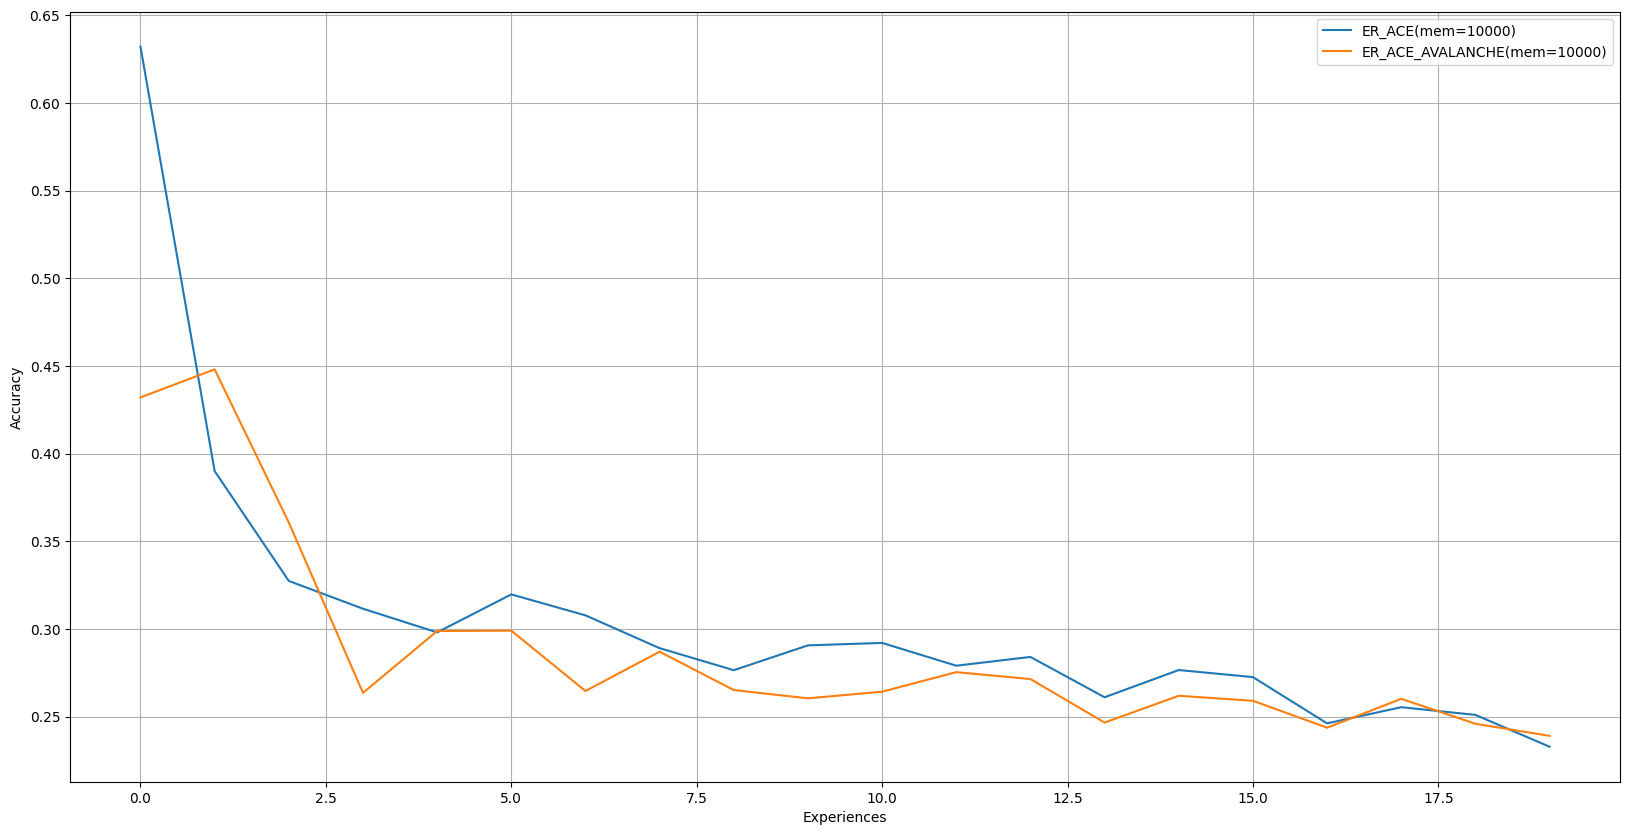

In [8]:
plt.figure(figsize=(20, 10))
plt.plot([sum(v.values()) / len(v.values()) for v in ERACE_results], label='ER_ACE(mem=10000)')
plt.plot([sum(v.values()) / len(v.values()) for v in ERACE_AVALANCHE_results], label='ER_ACE_AVALANCHE(mem=10000)')
plt.xlabel('Experiences')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In the end of this experiment we can tell that ER_ACE is slightly better in performance with respect to ER_ACE_AVALANCHE according to AAA while is similar in terms of accuracy. According efficiency ER_ACE_AVALANCHE is better because update the buffer only one time before the experience instead of in every iteration of experience as in ER_ACE.